#### Purpose of this notebook: collecting and testing in practice various algorithms used for clustering.
1. How to use them?
2. How to evaluate their quality?
3. What are some use-cases?
4. What needs to be kept in mind when using them?

## Import of libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

C:\Users\rosom\AppData\Local\Temp\ipykernel_10064\1889808001.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading and preparing the dataset

In [2]:
df = pd.read_csv("apartments_for_clustering.csv")

In [3]:
df.drop(axis=1,columns=("Price category"),inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89264 entries, 0 to 89263
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   89264 non-null  int64  
 1   Bathrooms                    89264 non-null  float64
 2   Bedrooms                     89264 non-null  float64
 3   Fee                          89264 non-null  int64  
 4   Price                        89264 non-null  float64
 5   Square_feet                  89264 non-null  float64
 6   Latitude                     89264 non-null  float64
 7   Longitude                    89264 non-null  float64
 8   Population                   89264 non-null  float64
 9   Basketball                   89264 non-null  int64  
 10  Alarm                        89264 non-null  int64  
 11  Hot Tub                      89264 non-null  int64  
 12  Washer Dryer                 89264 non-null  int64  
 13  Cable or Satelli

In [5]:
# Taking 2 columns and sample of 1000 rows from df for a simple visualisation of the process
X = df[['Price','Square_feet']].sample(10000)

### K-means clustering

Advantages of K-Means:

Fast and computationally efficient, especially on large datasets.

Easy to understand and implement.

Works well with spherical, evenly sized clusters.

Scales well with the number of samples.

Disadvantages of K-Means:

Requires predefined number of clusters (k).

Sensitive to initial centroid placement; can converge to local minima.

Assumes clusters are convex and isotropic; struggles with irregular shapes.

Sensitive to outliers and noise.

Performs poorly with categorical or mixed-type data.

##### Implementation

In [6]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.model_selection import train_test_split

#X,y = train_test_split(  df,test_size=0.2,random_state=42)
k = 6
k_means = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=k,random_state=42)
)
y_pred = k_means.fit_predict(X)
# Extract PCA and KMeans from the pipeline
scaler = k_means.named_steps['standardscaler']
kmeans = k_means.named_steps['kmeans']

# kmeans.labels_ - accessing the array of the predicted labels
# kmeans.cluster_centers_ - showing the centers of the found clusters

##### Plotting decision boundaries

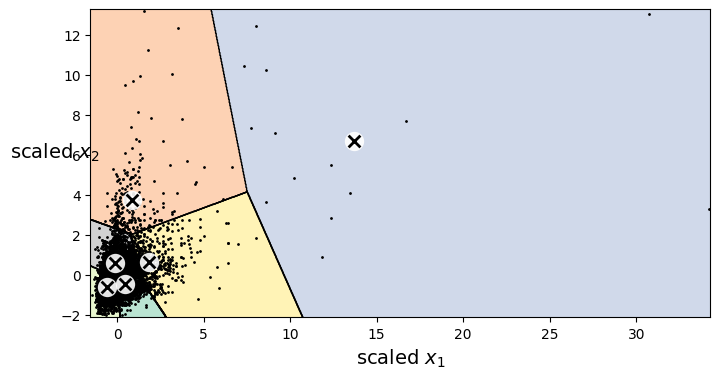

In [7]:
def plot_data(X):
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000,
                             show_centroids=True, show_xlabels=True, show_ylabels=True):
    # Get the scaler and the clustering model
    scaler = clusterer.named_steps['standardscaler']  # Use your actual step name
    kmeans = clusterer.named_steps['kmeans']          # Use your actual clustering step name

    # Transform the data
    X_scaled = pd.DataFrame(scaler.transform(X))

    # Create a grid in scaled space
    mins = X_scaled.min(axis=0) - 0.1
    maxs = X_scaled.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict cluster index for each point in the grid
    Z = kmeans.predict(grid).reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, Z, cmap="Pastel2", alpha=0.9)
    plt.contour(xx, yy, Z, linewidths=1, colors='k')

    # Plot scaled data
    plot_data(X_scaled)

    # Plot centroids in scaled space
    if show_centroids:
        plot_centroids(clusterer.named_steps['kmeans'].cluster_centers_)

    if show_xlabels:
        plt.xlabel("scaled $x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.ylabel("scaled $x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(k_means, X)
plt.show()

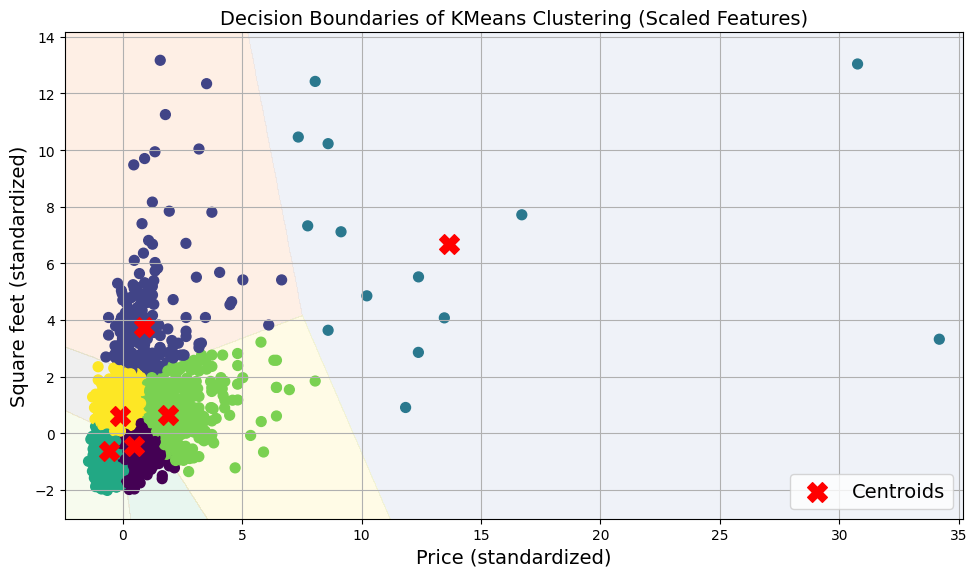

In [8]:
# Transform the data and keep feature names
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

# Create mesh grid in scaled space
x_min, x_max = X_scaled['Price'].min() - 1, X_scaled['Price'].max() + 1
y_min, y_max = X_scaled['Square_feet'].min() - 1, X_scaled['Square_feet'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict labels for mesh grid points
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries and data
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel2')

# Scatter original data (in scaled space)
plt.scatter(X_scaled['Price'], X_scaled['Square_feet'], 
            c=kmeans.labels_, cmap='viridis', s=50)

# Centroids (already in scaled space)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', marker='X', label='Centroids')

# Labels
plt.title("Decision Boundaries of KMeans Clustering (Scaled Features)")
plt.xlabel("Price (standardized)")
plt.ylabel("Square feet (standardized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




#### Searching for the optimal number of clusters

##### Checking inertia - elbow method (more general approach, lower computation cost)

In [24]:
from sklearn.metrics import silhouette_score
k_values = range(2, 10)
inertias,silhouettes = [],[]

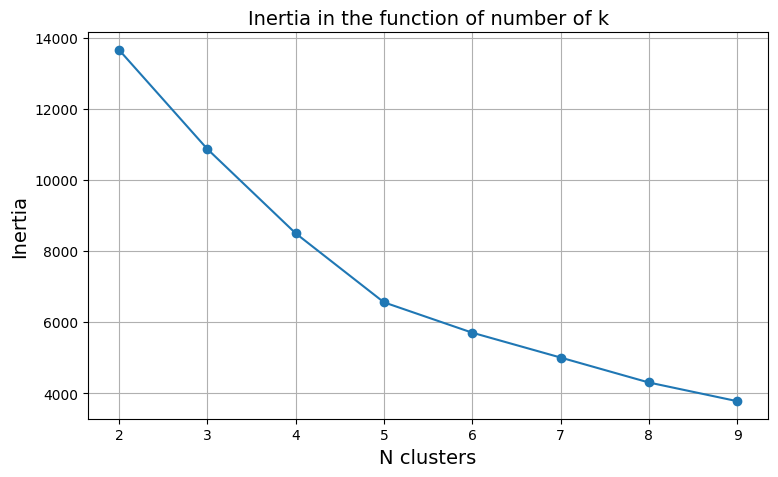

In [10]:
# Oblicz bezwładność dla każdej wartości k
for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k, random_state=42)
    )
    pipeline.fit(X)
    # Pobierz model KMeans z pipeline
    kmeans_model = pipeline.named_steps['kmeans']
    inertias.append(kmeans_model.inertia_)

# Narysuj wykres
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Inertia in the function of number of k')
plt.xlabel('N clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Checking silhouette score - the bigger the better (more precise and more computation heavy approach)

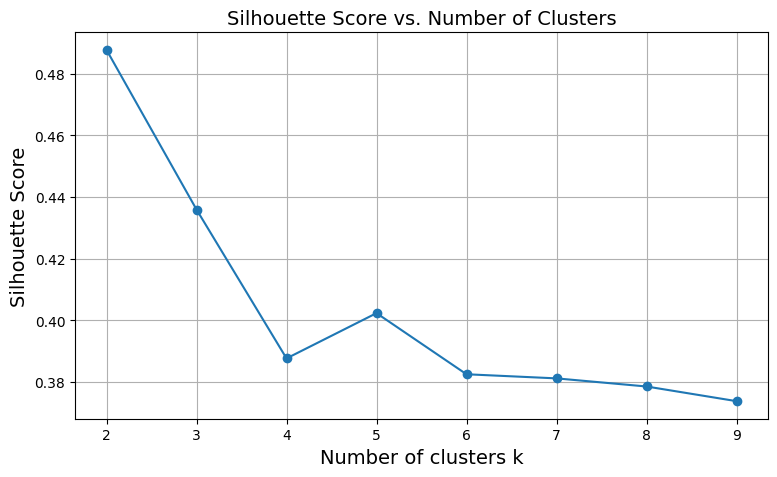

In [11]:
for k in k_values:
    if k < 2:
        continue  # Silhouette score requires at least 2 clusters
    
    pipeline = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k, random_state=42)
    )
    pipeline.fit(X)
    
    # Get scaled data and KMeans model
    X_scaled = pipeline.named_steps['standardscaler'].transform(X)
    kmeans_model = pipeline.named_steps['kmeans']
    
    labels = kmeans_model.labels_
    if len(set(labels)) < 2:
        continue  # Skip silhouette score if only 1 cluster was formed
    
    score = silhouette_score(X_scaled, labels)
    silhouettes.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouettes, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Silhouette diagram

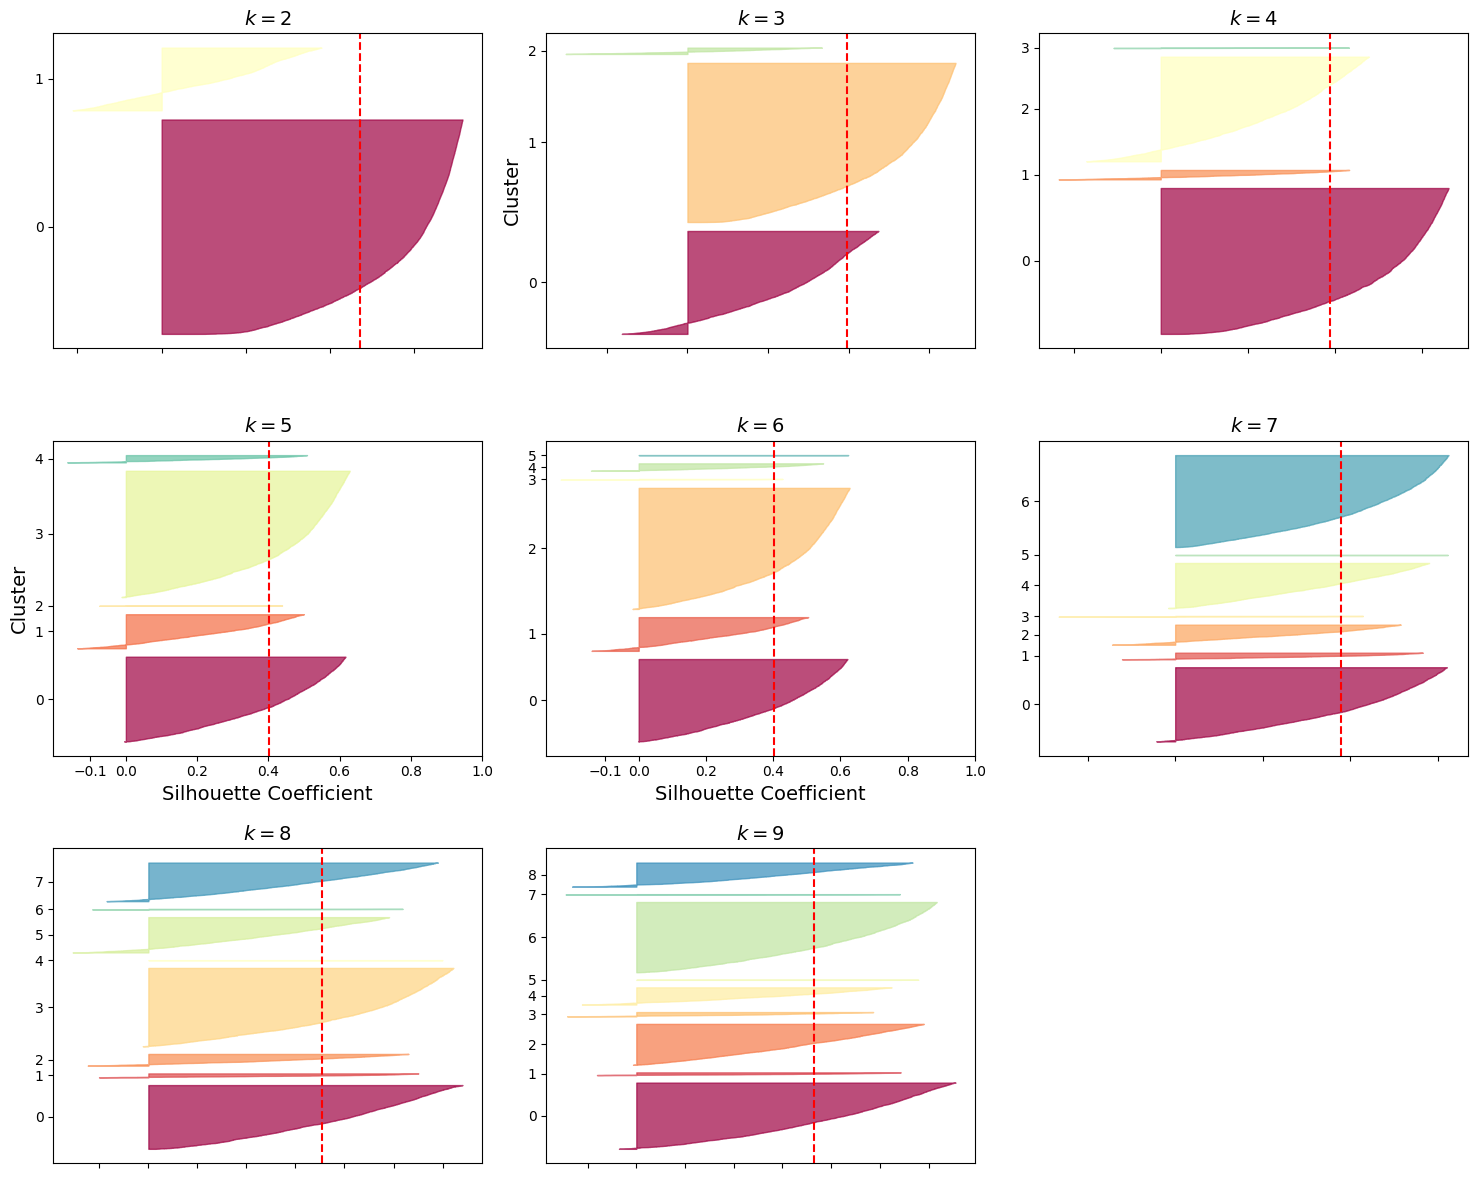

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import math

# Assume X is defined
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use k=2 to 9
#k_values = list(range(2, 10))

# Fit KMeans and compute silhouette scores
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled) for k in k_values]
silhouette_scores = [silhouette_score(X_scaled, model.labels_) for model in kmeans_per_k]

# Plotting
cols = 3
rows = math.ceil(len(k_values) / cols)
plt.figure(figsize=(5 * cols, 4 * rows))

for i, k in enumerate(k_values):
    plt.subplot(rows, cols, i + 1)
    kmeans = kmeans_per_k[i]
    y_pred = kmeans.labels_
    silhouette_coeffs = silhouette_samples(X_scaled, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []

    for cluster in range(k):
        coeffs = silhouette_coeffs[y_pred == cluster]
        coeffs.sort()
        color = plt.cm.Spectral(cluster / k)

        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if k in (3, 5):
        plt.ylabel("Cluster")
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[i], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.tight_layout()
plt.show()
